The Kentucky Derby is on Saturday, and a field of 20 horses is slated to run “the fastest two minutes in sports” in pursuit of the right to be draped with a blanket of roses. But let’s consider, instead, the Lucky Derby, where things are a little more bizarre:

The bugle sounds, and 20 horses make their way to the starting gate for the first annual Lucky Derby. These horses, all trained at the mysterious Riddler Stables, are special. Each second, every Riddler-trained horse takes one step. Each step is exactly one meter long. But what these horses exhibit in precision, they lack in sense of direction. Most of the time, their steps are forward (toward the finish line) but the rest of the time they are backward (away from the finish line). As an avid fan of the Lucky Derby, you’ve done exhaustive research on these 20 competitors. You know that Horse One goes forward 52 percent of the time, Horse Two 54 percent of the time, Horse Three 56 percent, and so on, up to the favorite filly, Horse Twenty, who steps forward 90 percent of the time. The horses’ steps are taken independently of one another, and the finish line is 200 meters from the starting gate.

Handicap this race and place your bets! In other words, what are the odds (a percentage is fine) that each horse wins?

Extra credit: Animate this derby. I’ll broadcast the highlights next week.

In [44]:
import random
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import rc
import itertools
from matplotlib import animation
from IPython.display import HTML
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import clear_output
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.cm as cm
import matplotlib.colors as col
import numpy as np

rc('animation', html='html5')

In [2]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [3]:
def format_time(time):
    m, s = divmod(int(time), 60)
    min_text = "   "
    
    if m > 0:
        min_text = "{0:>2d}m".format(m)
        
    return "{0} {1:>2d}s".format(min_text,s)

In [156]:
class Horse:
    step = 1
    
    def __init__(self, odds):
        self.odds = odds
        self.position = 0
        self.finished = False
        
    def take_step(self, race_distance):
        if not self.finished:
            if random.random() < self.odds:
                self.position += self.step
                if self.position >= race_distance:
                    self.position = race_distance
                    self.finished = True
            else:
                self.position -= self.step
        
        return self.position

In [157]:
class Race:
    
    def __init__(self, horse_odds, distance):
        self.distance = distance
        self.horses = [Horse(odd) for odd in horse_odds]
        
    def run_race(self):
        self.results = [[0 for _ in self.horses]]
        while not all([h.finished for h in self.horses]):
            self.results.append([h.take_step(self.distance) for h in self.horses])
        
    def race_time(self):
        return len(self.results)

    def num_horses(self):
        return len(self.horses)

In [158]:
ODDS = [.5 + .02*i for i in range(1, 21)]
LENGTH = 200
CMAP = cm.ScalarMappable(col.Normalize(0, len(ODDS)), cm.rainbow)

In [159]:
derby = Race(ODDS,LENGTH)
derby.run_race()

In [160]:
def plot_positions(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, h in enumerate(list(zip(*race.results))):
        ax.plot(h, color=cmap.to_rgba(i), linewidth=1)

    ymin,ymax = ax.get_ylim()
    ax.set_ylim(ymin, race.distance)
    ax.set_xlim(0, race.race_time())
    plt.show()

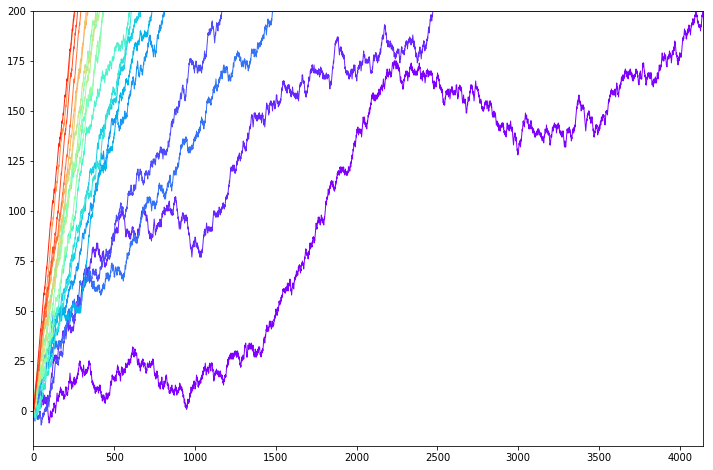

In [161]:
plot_positions(derby, CMAP)

In [185]:
def plot_finish_times(race, cmap):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    finish_times = [h.index(race.distance) for h in list(zip(*race.results))]
    odds = [h.odds for h in race.horses]
    horse_indices = list(range(race.num_horses()))
    
    
    ax.set_xlim([-0.5, horse_indices[-1]+0.5])
    ax.xaxis.set_ticks(horse_indices)
    ax.xaxis.set_ticklabels(["{:<2.0f}".format(o*100) for o in odds])
    ax.yaxis.set_major_locator(MultipleLocator(600))
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/60)))
    
    ax.grid(b=True, which='major', axis='y', linestyle='--')
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', left='off', right='off')
    ax.bar(horse_indices,
           finish_times,
           edgecolor='black',
           linewidth=2,
           color=cmap.to_rgba(horse_indices),
           zorder=10)
    ax.set_title("Finish Time vs. Odds Horse Advances")
    ax.set_xlabel("Odds Horse Advances [%]")
    ax.set_ylabel("Finish Time [min]")
    plt.show()

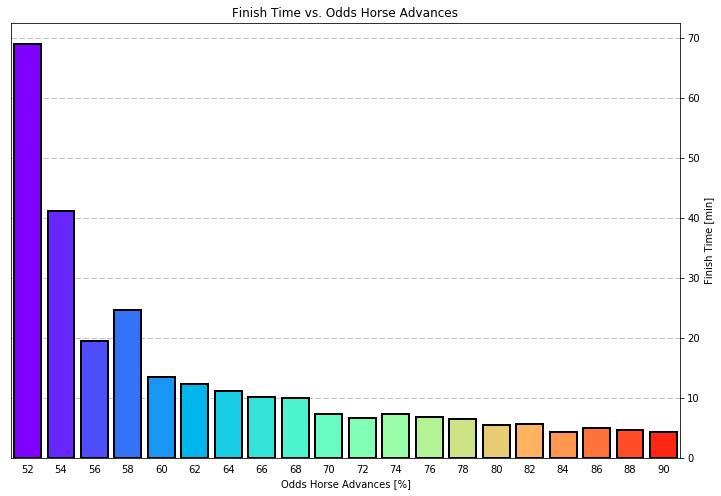

In [186]:
plot_finish_times(derby, CMAP)

In [187]:
def create_axes(race, cmap):
    xmin = min(min(r) for r in race.results)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axvline(color="white")
    
    dots = []
    finish_times = []
    for i in range(race.num_horses()):
        dot = ax.plot([], 
                      [] ,
                      'o', 
                      markersize=10,
                      color=cmap.to_rgba(i))
        time = ax.text(race.distance-5, i+0.5, "", 
                       color="white",
                       verticalalignment='center',
                       horizontalalignment='right',
                       family='monospace',
                       size='large')
        dots.append(dot[0])
        finish_times.append(time)
    
    
    
    ax.set_facecolor('#573B0C')
    ax.set_position([0, 0, 1, 1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off')
    ax.set_xlim([xmin, race.distance])
    ax.set_ylim([0, race.num_horses()])
    return fig, dots, finish_times

In [188]:
def update_axes(frame_num, dots_gen, fig, dots, finish_times, race):
    next_dot_positions = next(dots_gen)
    for i, (dot, next_pos, finish) in enumerate(zip(dots, next_dot_positions, finish_times)):
        dot.set_xdata(next_pos)
        dot.set_ydata(i+0.5)
        if next_pos >= race.distance and finish.get_text() == "":
            finish.set_text(format_time(frame_num))
    
    return fig, dots, finish_times

In [189]:
def create_animation(race, cmap, frames=None, delay_frames=None):
    if delay_frames is None:
        delay_frames = 250
    
    positions = race.results + delay_frames*[race.results[-1]]
    dots_gen = itertools.cycle(positions)
    
    if frames is None:
        frames = len(positions)
        
    fig, dots, finish_times = create_axes(race, cmap)
    line_ani = animation.FuncAnimation(fig,
                                       update_axes,
                                       frames=frames,
                                       fargs=(dots_gen, fig, dots, finish_times, race),
                                       repeat=True,
                                       interval=50,
                                       save_count=frames)

    return line_ani

In [192]:
create_animation(derby, CMAP)

In [193]:
from scipy.stats import binom
from scipy.special import binom as binom_coeff

In [194]:
ns = range(200,500)

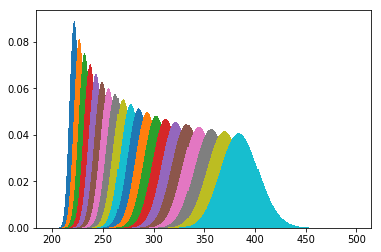

In [212]:
for o in reversed(ODDS):
    plt.bar(ns, [binom.pmf(LENGTH, n,o) for n in ns], width=1)
plt.show()

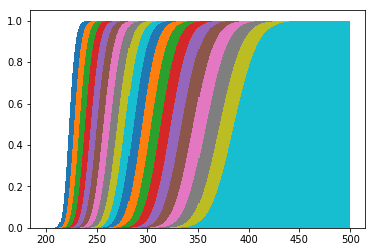

In [208]:
for o in reversed(ODDS):
    plt.bar(ns, [binom.sf(LENGTH, n, o) for n in ns], width=1)
plt.show()

In [209]:
pmfs = [[binom.pmf(LENGTH, n, o) for n in ns] for o in reversed(ODDS)]

pmfs_inv = list(zip(*pmfs))

In [210]:
results = []
for odd in pmfs_inv:
    temp = []
    for j in range(len(odd)):
        prob_fin = odd[j]
        prob_other_not_fin = np.prod([1-x for i,x in enumerate(odd) if i!=j])
        prob_winner = prob_fin*prob_other_not_fin
        temp.append(prob_winner)
    results.append(temp)

In [201]:
def partial_probability(k, odds, index):
    first_term = binom_coeff(k-1, LENGTH-1)*(odds[index]**LENGTH)*((1-odds[index])**(k-LENGTH))
    
    other_terms = np.prod([np.sum(binom.pmf(j,k,odds[i]) for j in range(LENGTH)) 
                       for i in range(len(odds)) if i != index])
    
    return first_term * other_terms

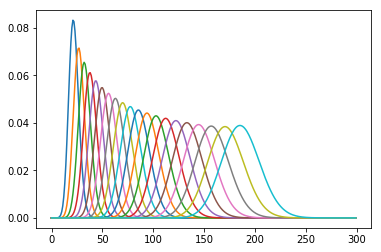

In [211]:
for r in zip(*results):
    plt.plot(r)
plt.show()

$L$ = race length    
$N$ = number of horses    
$p_n$ = probability that horse $n$ moves forward

$$(\lambda)_n = \frac{\Gamma(\lambda + N)}{\Gamma(\lambda)}$$

$${}_NF_{N-1}(a_0,\ldots,a_N;b_0,\ldots,b_{N+1};z) = \sum_{n=0}^\infty \frac{(a_0)_n \ldots (a_N)_n}{(b_0)_n \ldots (b_{N+1})_n} \frac{z^n}{n!}.$$

$$P_n = p_n^L \prod_{\substack{i=0 \\ i\neq n}}^{N} \sum_{j=0}^{L-1} {{L}\choose{j}} p_i^{j} (1-p_i)^{L-j}{}_NF_{N-1}(L,L+1\ldots;A-j+1\ldots;(1-p_n)\ldots)$$

In [328]:
import sympy
from sympy import symbols, hyper
from sympy import Sum
from sympy import init_printing
from sympy.physics.vector import vlatex

init_printing(latex_printer=vlatex, latex_mode='equation')

L = symbols('L')
horse_probs = symbols('p:3')
from sympy.abc import i,j,k,l,m,x

In [311]:
def bin_probs(L, p, j):
    coeff = sympy.functions.combinatorial.factorials.binomial(L,j)
    return coeff * p**j * (1-p)**(L-j)

In [312]:
bin_probs(L, j, horse_probs[0])

In [313]:
def recursive_sum(vars, func, fargs, low_lim, up_lim, init_val=1):
    if not vars:
        return init_val
    
    return recursive_sum(vars[:-1],
                         func,
                         fargs,
                         low_lim,
                         up_lim,
                         Sum(func(*fargs, vars[-1])*init_val, (vars[-1], low_lim, up_lim)))

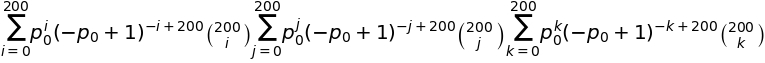

In [314]:
recursive_sum((i,j,k), bin_probs, (L,horse_probs[0]), 0, L)

In [331]:
horse_probs[0]**L * recursive_sum((x,), bin_probs, (L,horse_probs[1]), 0, L-1, hyper([L, L+1],[L-x+1],(1-horse_probs[0])*(1-horse_probs[1])))

    L - 1                                                              
     ____                                                              
     ╲                                                                 
      ╲     x          L - x ⎛L⎞  ┌─  ⎛ L, L + 1 │                    ⎞
  L    ╲  p₁ ⋅(-p₁ + 1)     ⋅⎜ ⎟⋅ ├─  ⎜          │ (-p₀ + 1)⋅(-p₁ + 1)⎟
p₀ ⋅   ╱                     ⎝x⎠ 2╵ 1 ⎝L - x + 1 │                    ⎠
      ╱                                                                
     ╱                                                                 
     ‾‾‾‾                                                              
    x = 0                                                              

In [336]:
horse_probs = (0.55,0.5)
L = 200
s = horse_probs[0]**L * recursive_sum((x,), bin_probs, (L,horse_probs[1]), 0, L-1, hyper([L, L+1],[L-x+1],(1-horse_probs[0])*(1-horse_probs[1])))
s

                      199                                                
                      ____                                               
                      ╲                                                  
                       ╲      x    -x + 200 ⎛200⎞  ┌─  ⎛200, 201 │      ⎞
                        ╲  0.5 ⋅0.5        ⋅⎜   ⎟⋅ ├─  ⎜         │ 0.225⎟
1.18178343675992e-52⋅   ╱                   ⎝ x ⎠ 2╵ 1 ⎝-x + 201 │      ⎠
                       ╱                                                 
                      ╱                                                  
                      ‾‾‾‾                                               
                     x = 0                                               

In [337]:
s.doit().evalf()

In [338]:
horse_probs = (0.5,0.55)
L = 200
s = horse_probs[0]**L * recursive_sum((x,), bin_probs, (L,horse_probs[1]), 0, L-1, hyper([L, L+1],[L-x+1],(1-horse_probs[0])*(1-horse_probs[1])))
s

                      199                                                  
                      ____                                                 
                      ╲                                                    
                       ╲       -x + 200     x ⎛200⎞  ┌─  ⎛200, 201 │      ⎞
                        ╲  0.45        ⋅0.55 ⋅⎜   ⎟⋅ ├─  ⎜         │ 0.225⎟
6.22301527786114e-61⋅   ╱                     ⎝ x ⎠ 2╵ 1 ⎝-x + 201 │      ⎠
                       ╱                                                   
                      ╱                                                    
                      ‾‾‾‾                                                 
                     x = 0                                                 

In [339]:
s.doit().evalf()

In [342]:
1 - (Out[337] + Out[339])

In [344]:
s = .5**200 * .55**200 * hyper([L, L],[1],(1-horse_probs[0])*(1-horse_probs[1]))
s.doit().evalf()